# Random Forest Model

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd 
import feather 

from sklearn.metrics import roc_auc_score, roc_curve
import joblib

from database import Database
from utils import Utils

db = Database('Mimir from Munnin')
u = Utils()
np.random.seed(u.RANDOM_STATE)

In [2]:
df_patients = u.load_df('df_patients')
df_patients = df_patients.sort_values(by='PID')

model = joblib.load(u.DATA_PATH+'PSM_models/RF/Best.pkl')
clf = model['classifier']
clf

In [11]:
print("Out of Bag Score: ", round(clf.oob_score_, 3))

Out of Bag Score:  0.634


In [12]:
p_scores = clf.oob_decision_function_[:, 1] # 1 is idx where clf.classes_ == 1
df_patients['Propensity'] = p_scores

In [ ]:
# u.save_df(df_patients, 'df_propensity')

## Figures

In [5]:
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Arial")
set_style()

### Feature Importances

In [6]:
# Feature Importances 

idx = np.argsort(clf.feature_importances_)[-20:]
drugs = u.load_np('drugs')
feat_name = []
for drugID in drugs[sorted(idx)]: 
    q = 'select atc_5_name from atc_5_name where atc_5_id = ' + str(drugID)
    name = db.get_list(q)[0]
    feat_name.append(name)
feat_imp = clf.feature_importances_[sorted(idx)]

#plt.barh(feat_name, feat_imp)
#plt.title("Top Features")
#plt.show()

new_idx = np.argsort(feat_imp)
new_name = [feat_name[x].title() for x in new_idx]
new_imp = sorted(feat_imp)

Connection opened successfully.


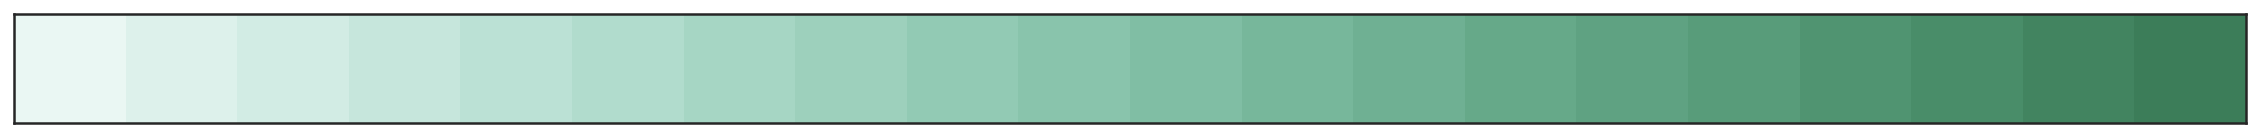

In [7]:
n_colors = len(new_name)
custom_palette = sns.light_palette((210, 90, 60), n_colors=n_colors,input="husl")
custom_palette = sns.cubehelix_palette(n_colors, start=2, rot=0.1, dark=0.95, light=.4, reverse=True)
sns.set_palette(custom_palette)
sns.palplot(custom_palette)

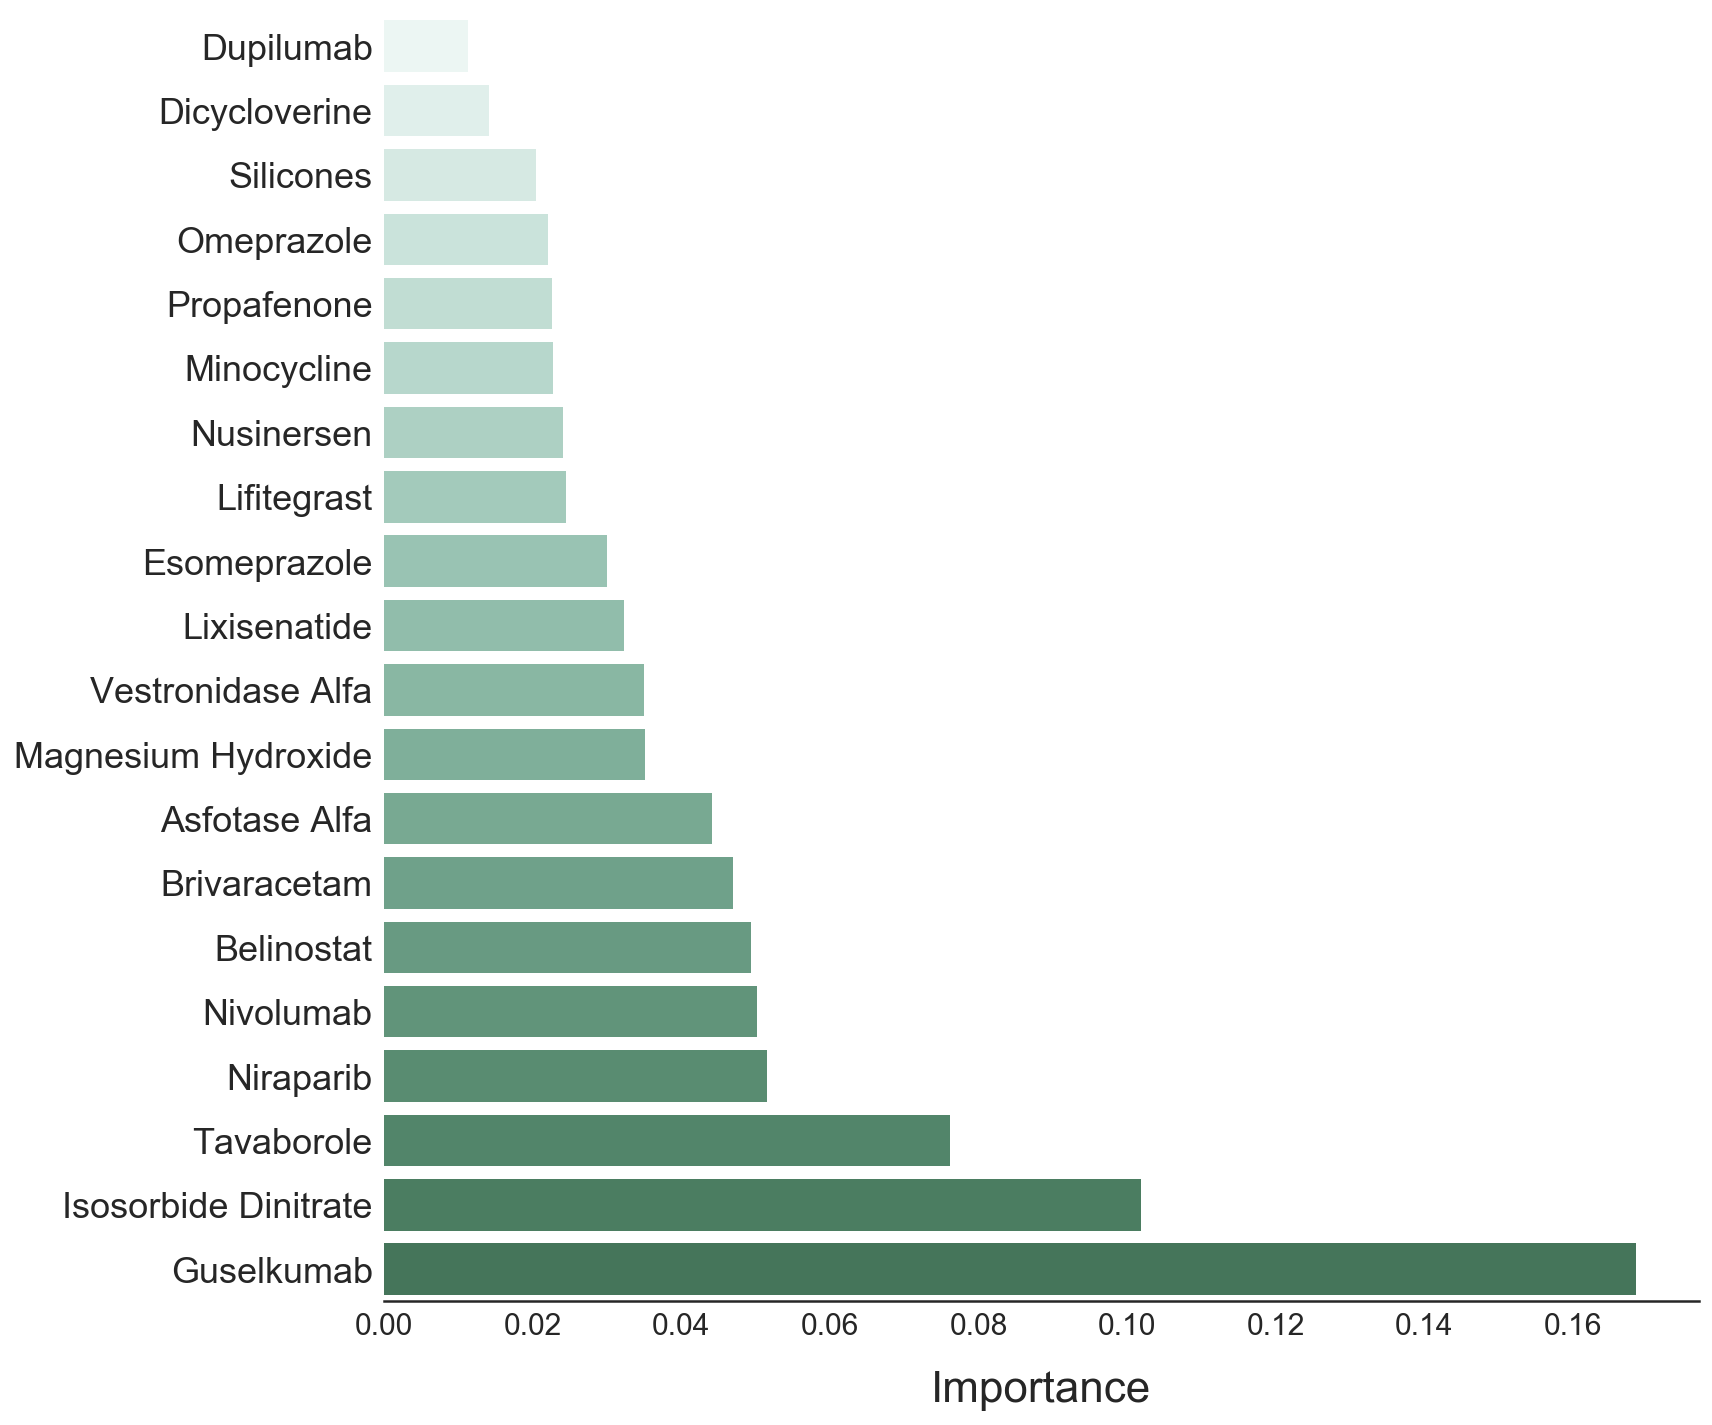

In [8]:
set_style()
fig, ax = plt.subplots(1, sharex=False, sharey=False, figsize=(12,10))
ax = fig.get_axes()[0]

sns.barplot(new_imp,new_name, ax=ax, palette=custom_palette)

sns.despine(left=True, bottom=False)

ax.set_xlabel('Importance', fontsize=22, labelpad=15)
ax.tick_params('y', labelsize=18)

#ax.set_title('Top features from Random Forest model', fontsize=22, pad=20)

ax.tick_params('x',labelsize=15)
plt.tight_layout()
plt.show()

### ROC curve

In [14]:
y_true = df_patients.get('Sex').replace('F', 1).replace('M', 0).values
y_pred = df_patients.get('Propensity').values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

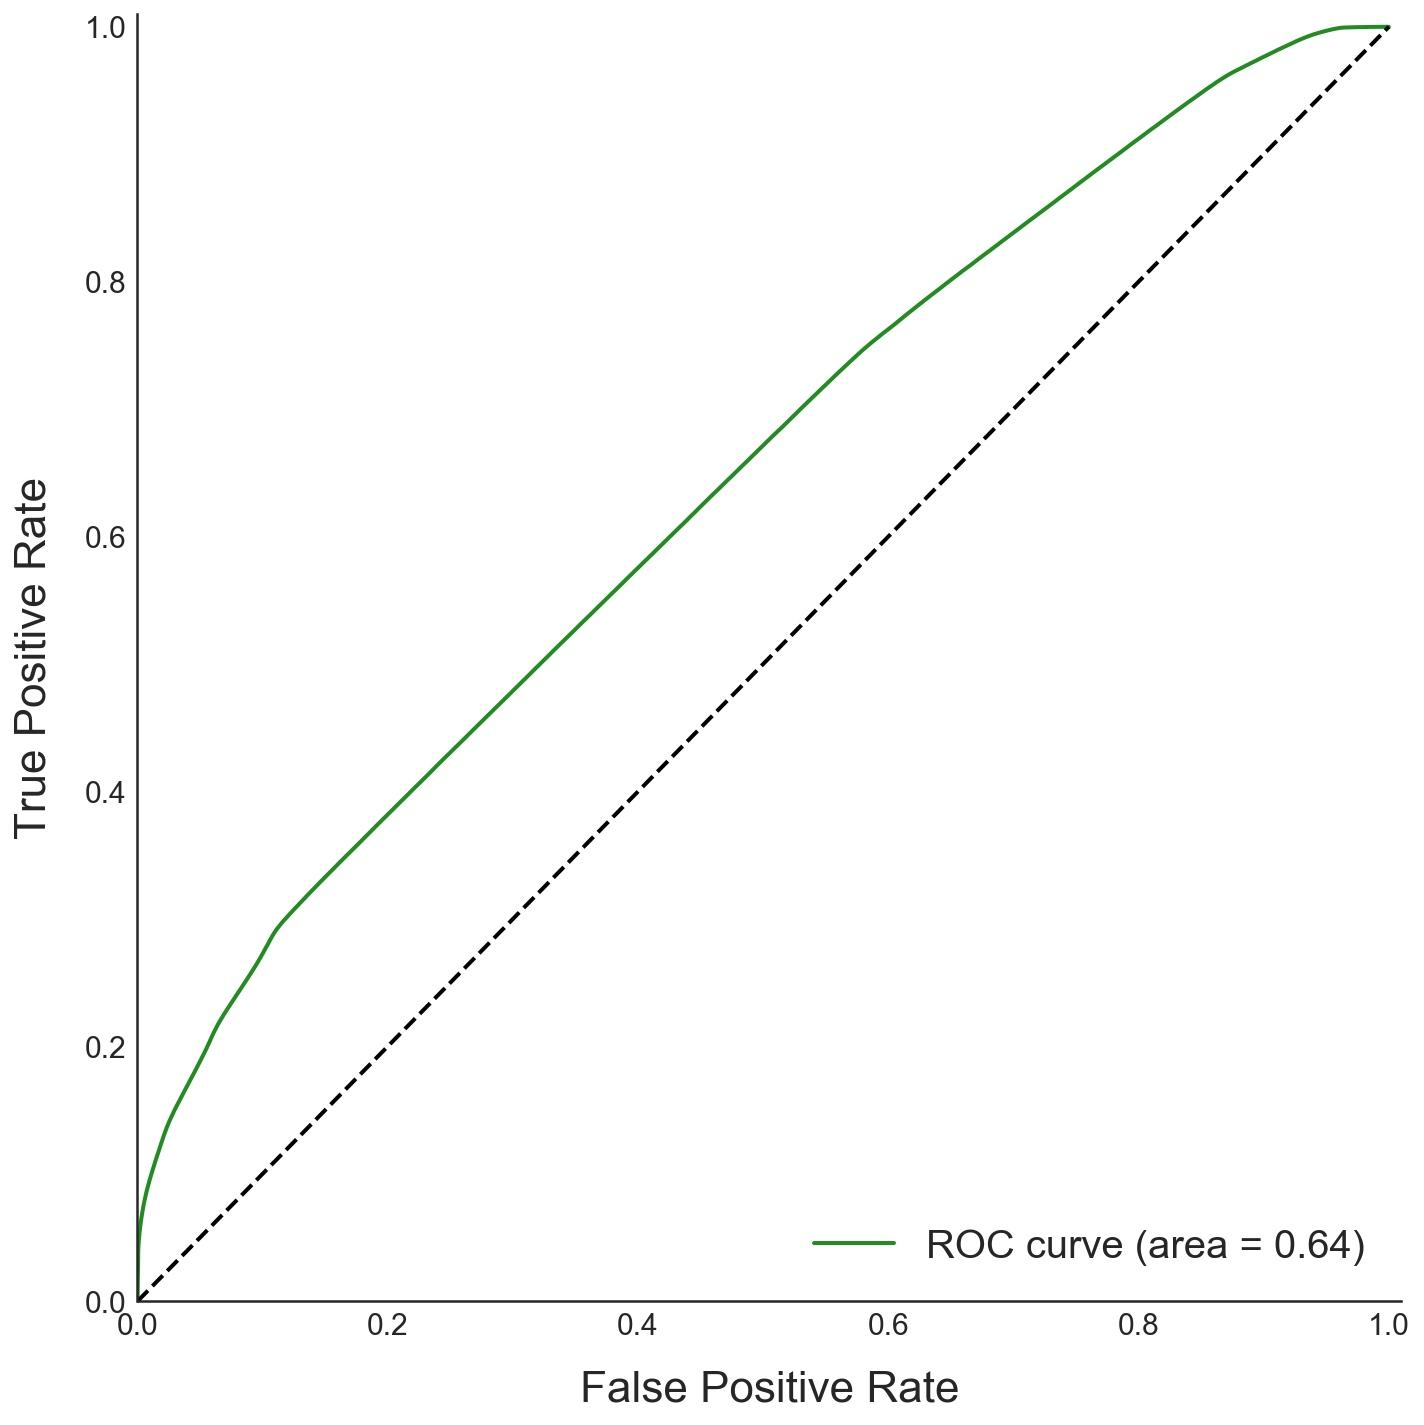

In [15]:
set_style()
fig, ax = plt.subplots(1, sharex=False, sharey=False, figsize=(10,10))
ax = fig.get_axes()[0]

x_lim = (0,1.01)
y_lim = (0,1.01)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

lw=2
ax.plot(fpr, tpr, color='forestgreen', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')


plt.xlabel('False Positive Rate', fontsize=22, labelpad=15)
plt.ylabel('True Positive Rate', fontsize=22, labelpad=15)
#plt.title('Receiver operating characteristic curve', fontsize=16, pad=20)

ax.tick_params(labelsize=15)
sns.despine(left=False, bottom=False, offset=0.1)
plt.legend(loc="lower right", fontsize=20)
plt.tight_layout()
plt.show()

### Propensity scores distribution

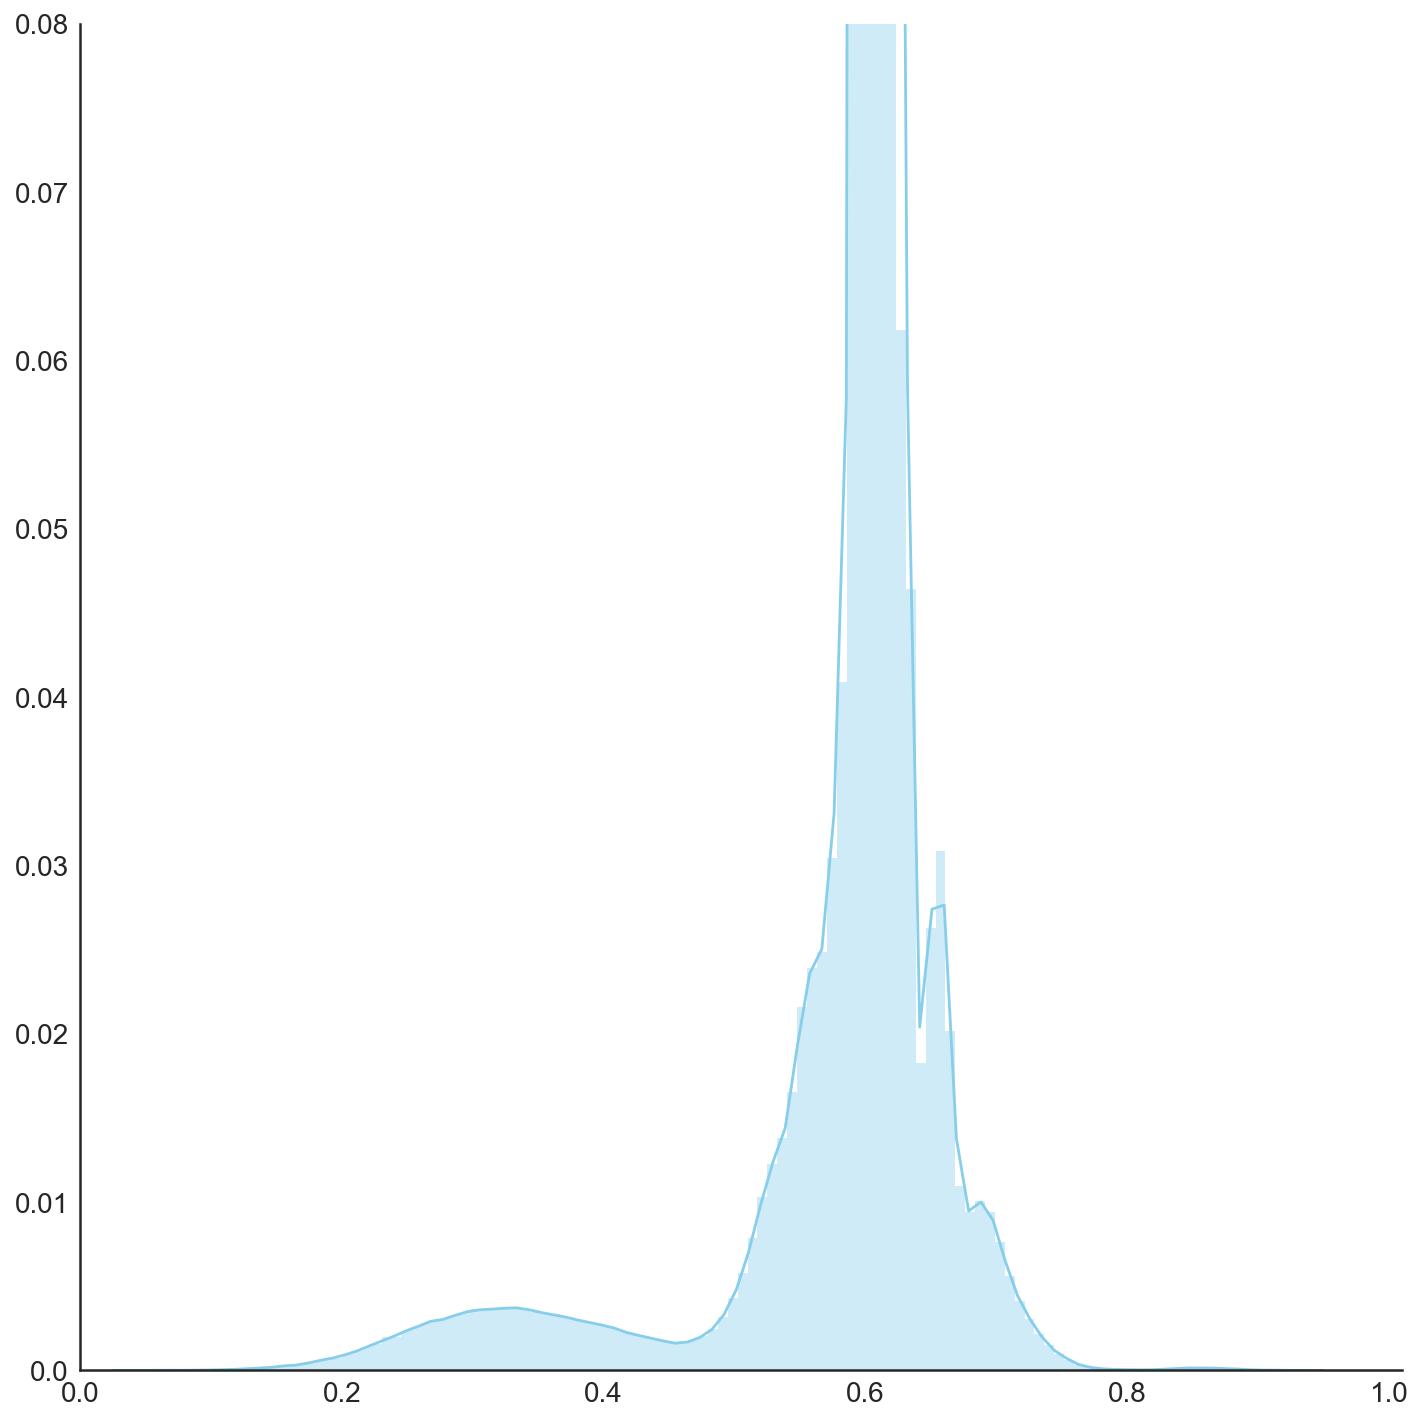

In [14]:
set_style()
fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(10,10))

x_lim = (0,1.01)
y_lim = (0,4)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

b=120
sns.distplot(df_patients.query('Sex=="M"').get('Propensity'),bins=b, color='skyblue', ax=ax)

sns.despine()

ax.tick_params(labelsize=14)

ax.set_yticklabels([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08],minor=False)

ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.show()

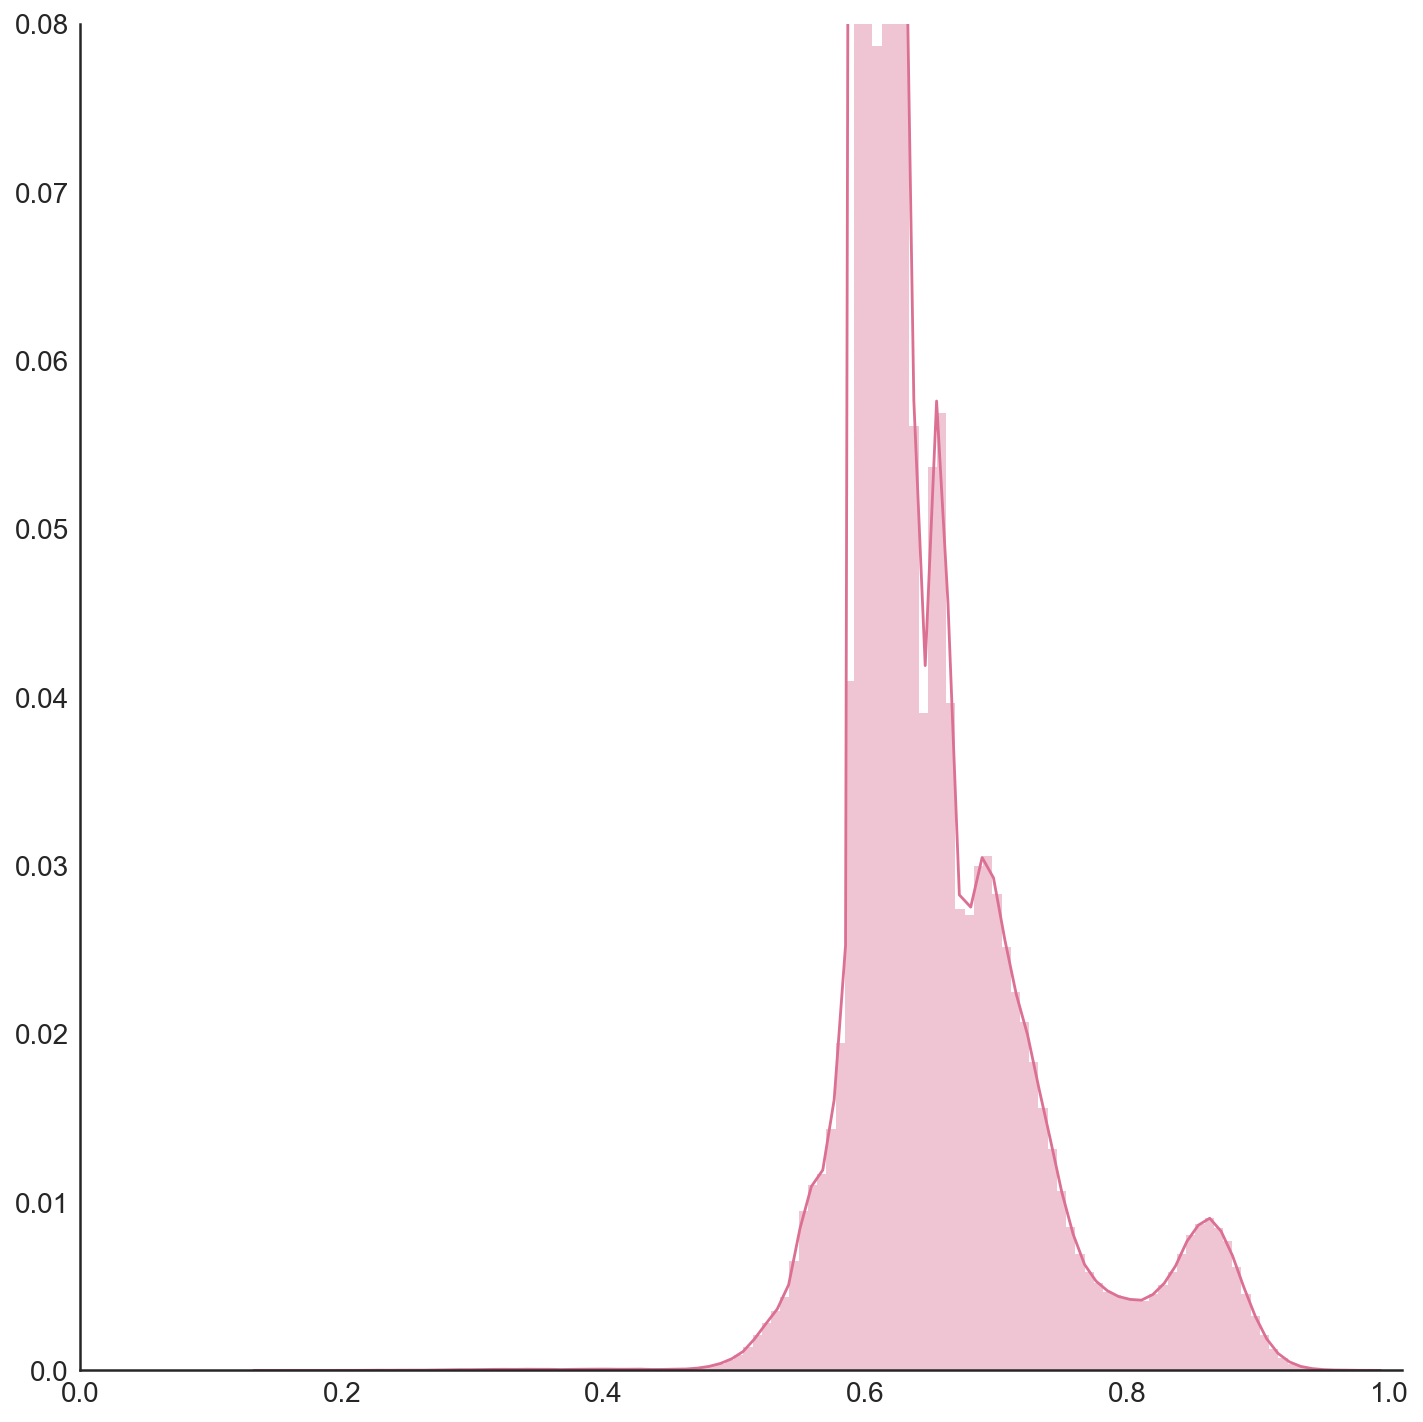

In [15]:
set_style()
fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(10,10))

x_lim = (0,1.01)
y_lim = (0,4)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

b=120
sns.distplot(df_patients.query('Sex=="F"').get('Propensity'),bins=b, color='palevioletred', ax=ax)

sns.despine()

ax.tick_params(labelsize=14)

ax.set_yticklabels([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08],minor=False)

ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.show()